In [1]:
import sys
sys.path.append("..")

In [2]:
# Scientific computing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from random import randint
import random

# Image processing libraries
from PIL import Image
import scipy.ndimage
import matplotlib.image as mpimg


# File IO libraries
import shutil
import glob
from pathlib import Path
import os

# Machine learning libraries
from sklearn.model_selection import train_test_split

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications, optimizers, regularizers
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, Input
from keras.applications.vgg16 import VGG16 

Using TensorFlow backend.


### Import and preprocessing

In [3]:
# Define function to read bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)

def read_raw_from_dir(fn):
    x = Image.open(fn)

    x = x.convert('L') # makes it greyscale - CLaMM data is grayscale
    y=np.asarray(x.getdata(),dtype='uint8').reshape((x.size[1],x.size[0]))
    return y

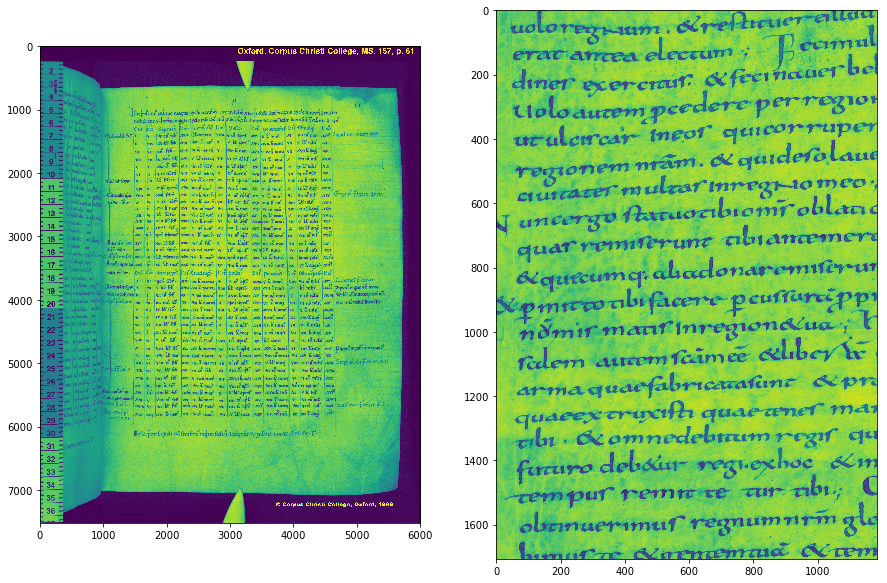

In [4]:
# Read image from each dataset and plot
im = read_raw_from_dir("Data/61.jpg") 
im2 = read_raw_from_dir('Data/ICDAR2017_CLaMM_Training/btv1b8426780x_f206.tif')

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(im)
axarr[1].imshow(im2)

In [5]:
### Reading the data description of the CLaMM dataset, we find that the images are 150mm*100mm, so we need to 
### take similar-sized crops from our new target data. Looking at the bar on the left, we find that 6000px = 
### (341-47) = 294mm. So  1mm = 20.41px. We therefore need to crop 3062 * 2041px from the original. However,
### to not give away too much, we need to make this crop a little random. Looking at the test images, 
### 1) Their heights vary by around 100px AFTER downsampling, so around 170px BEFORE downsampling.
### 2) Their widths vary by proportionately less, around 65px AFTER, so 110px BEFORE.

### We define a crop function below which achieves precisely this.

### Think about absolute size of script in training.

In [6]:
def image_oc_crop(img, dimensions, top_left_pt): #gives an offset crop, starting at top_left_pt pixels 
    # in original image
    """
    Makes a crop of an img, with coordinates of the top left corner top_left_pt, and of side lengths
    "dimensions" using numpy slicing.
    """
    lh = top_left_pt[0]
    lw = top_left_pt[1]
    
    hdim = round(dimensions[0] + randint(-85, 85)) # randomization not really necessary
    wdim = round(dimensions[1] + randint(-55, 55))
    
    cropped_img = img[lh:lh+hdim,lw:lw+wdim]
    
    return cropped_img

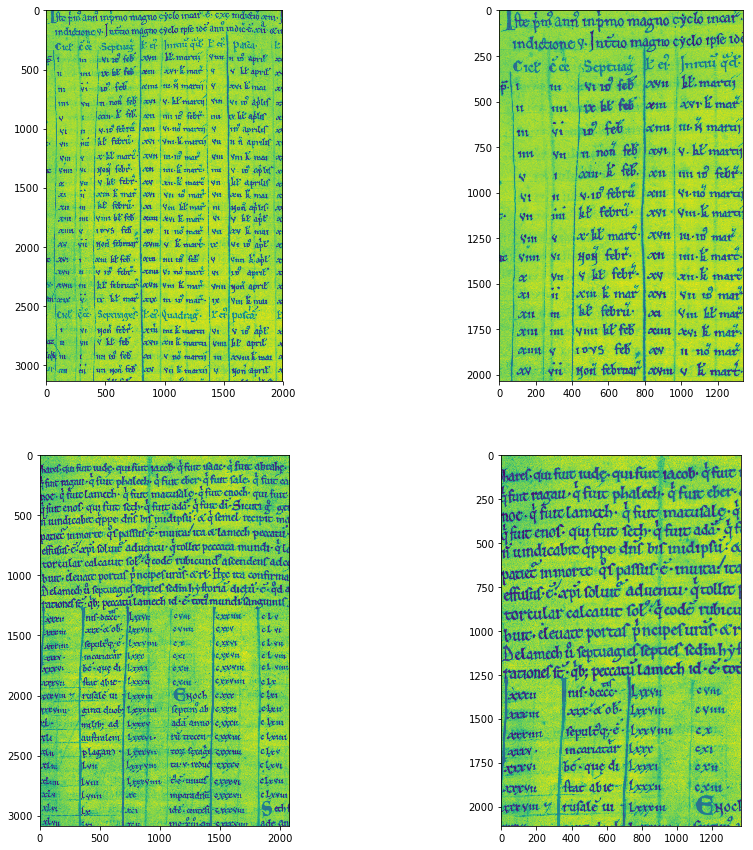

In [7]:
# Crop images and plot to check cropping works well
new_im = read_raw_from_dir("Data/101.jpg")
CORNER = [1000,1400]
DIM = [3062,2041]

f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0,0].imshow(image_oc_crop(im,DIM,CORNER))
axarr[0,1].imshow(image_oc_crop(im,[x * 2/3 for x in DIM], CORNER))
axarr[1,0].imshow(image_oc_crop(new_im, DIM, CORNER))
axarr[1,1].imshow(image_oc_crop(new_im,[x * 2/3 for x in DIM], CORNER))

/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


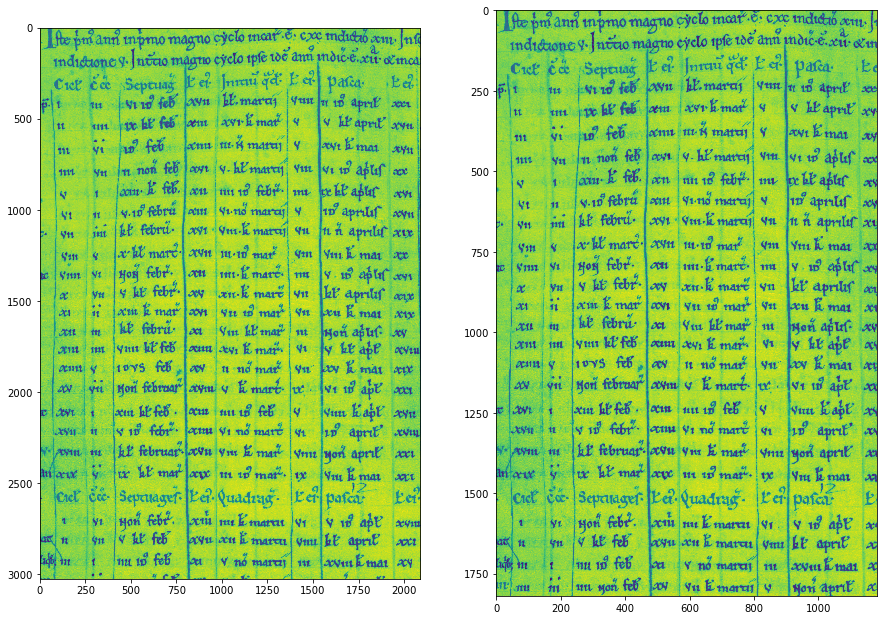

In [8]:
# Resample images to make them a similar number of pixels to CLaMM dataset
def resample_image(img, scale):
    resampled = scipy.ndimage.zoom(img, 1/scale, order=3) # retain a single image channel for now, add conv layer later
    output = resampled.astype('uint8')
    return output

# To match the training data, we need to downsample by a factor of 1.7
SCALE = 1.7

resampled = resample_image(image_oc_crop(im,DIM,CORNER), SCALE)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(image_oc_crop(im,DIM,CORNER))
axarr[1].imshow(resampled)

In [9]:
# Put everything together into one function to normalize and crop data
def prepare_raw_bytes_for_model(input_path):
    input_mat = read_raw_from_dir(input_path)
    inpt = image_oc_crop(input_mat, DIM, CORNER)  # take squared center crop
    img = resample_image(inpt,SCALE)
    return img


In [10]:
THoW_im = prepare_raw_bytes_for_model("Data/21.jpg")
print(THoW_im.shape)
print(THoW_im)
### This bit throws a zoom warning, but the size of the array isn't a problem for us...

CLaMM_im = read_raw_from_dir('Data/ICDAR2017_CLaMM_Training/btv1b8426780x_f206.tif')

(1770, 1200)
[[192 194 194 ..., 218 222 227]
 [198 200 199 ..., 220 217 219]
 [199 199 195 ..., 216 214 218]
 ..., 
 [200 207 197 ..., 181 186 189]
 [195 199 188 ..., 180 177 188]
 [200 178 168 ..., 188 172 177]]


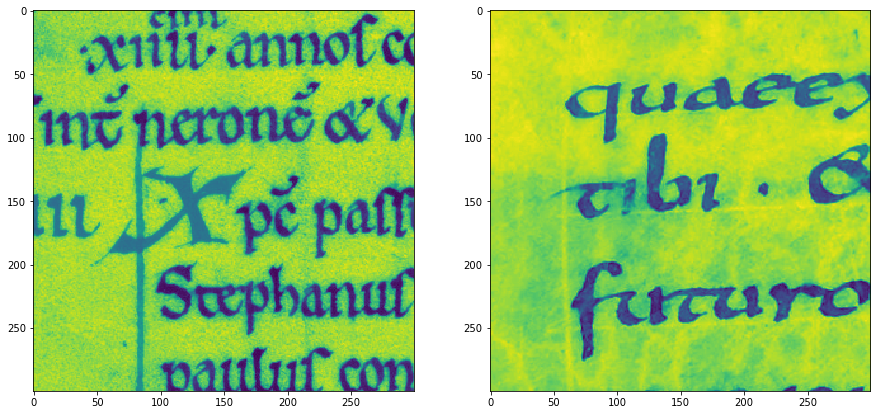

In [11]:
#write function to crop img_height by img_width sections from the original files.

def tile_crop(array, tile_height, tile_width):
    array_height, array_width = array.shape
    
    height_tiles = array_height//tile_height
    width_tiles = array_width//tile_width
    
    tile_list = []
    for i in range(height_tiles):
        for j in range(width_tiles):
            new_tile = array[i * tile_height: (i + 1) * tile_height, j * tile_width: (j + 1)* tile_width]
            tile_list.append(new_tile)
            
    return tile_list

THoW_listing = tile_crop(THoW_im, 300, 300)
len(THoW_listing)

CLaMM_listing = tile_crop(CLaMM_im, 300, 300)
len(CLaMM_listing)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(THoW_listing[12])
axarr[1].imshow(CLaMM_listing[12])

In [12]:
### Now read files, process and write out processed files to an external folder.
THoW_list = sorted(glob.glob("Data/*.jpg"))
clamm_list = sorted(glob.glob("Data/ICDAR2017_CLaMM_Training/*.tif"))

# clean out folio views etc, whose filenames start with a letter rather than a number
cleaned_THoW_list = [element for element in THoW_list if not element[5].isalpha()]

In [13]:
IM_HEIGHT = 300
IM_WIDTH = 300

# Define function to write all the cropped THoW tiles to data file
def write_all_THoW_data_to_jpg(file_path, input_file_list):
    counter = 0
    for element in input_file_list:
        THoW_im = prepare_raw_bytes_for_model(element)
        new_tile_list = tile_crop(THoW_im, IM_HEIGHT, IM_WIDTH)
        for i in range(len(new_tile_list)):
            tile_file_name = file_path + '/THoW'+str(counter + i)+".jpg"
            tensorized = np.dstack([new_tile_list[i]] * 3)
            im = Image.fromarray(tensorized)
            im.save(tile_file_name)
        counter += len(new_tile_list)
    return counter

root_path = Path.cwd()
THoW_data_path = Path(root_path, 'Data/new_processed/THoW')

#write_all_THoW_data_to_jpg(str(THoW_data_path), cleaned_THoW_list)

/Users/chrispedder/Desktop/Stat_Nac/Data/new_processed/THoW


In [14]:
# Define function to write first 500 tif files worth of cropped CLaMM tiles to data file

def write_all_CLaMM_data_to_jpg(file_path, input_file_list):
    counter = 0
    for element in input_file_list[:500]:
        CLaMM_im = read_raw_from_dir(element)
        print(CLaMM_im.shape)
        new_tile_list = tile_crop(CLaMM_im, IM_HEIGHT, IM_WIDTH)
        for i in range(len(new_tile_list)):
            tile_file_name = file_path + '/CLaMM'+str(counter + i)+'.jpg'
            tensorized = np.dstack([new_tile_list[i]] * 3)
            im = Image.fromarray(tensorized)
            im.save(tile_file_name)
        counter += len(new_tile_list)
    return counter

CLaMM_data_path = Path(root_path, 'Data/new_processed/CLaMM')

#write_all_CLaMM_data_to_jpg(str(CLaMM_data_path), clamm_list)

/Users/chrispedder/Desktop/Stat_Nac/Data/new_processed/CLaMM


In [15]:
# Define routine to delete all files in a given directory
def delete_all_files(path):

    files = glob.glob(path+'/*')
    for f in files:
        os.remove(f)

#delete_all_files(str(THoW_data_path))
#delete_all_files(str(CLaMM_data_path))

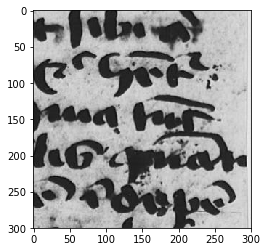

In [16]:
# Do train-test split of data into subfolders required for Keras retraining format

# Set number of samples from each dataset to use
SET_SIZE = 600 

# Set random seed to get the same train-test split when run
SEED = 42
random.seed(SEED)

THoW_sample_list = random.sample(glob.glob("Data/new_processed/THoW/*"), SET_SIZE)
CLaMM_sample_list = random.sample(glob.glob("Data/new_processed/CLaMM/*"), SET_SIZE)

# Plot example tile from the Clamm_sample_list
plt.imshow(mpimg.imread(str(CLaMM_sample_list[120])))

train_test_split = 0.25
split = round((1-train_test_split) * SET_SIZE)

THoW_tr_files = []
CLaMM_tr_files = []
for i in range(split):
    THoW_tr_files.append(THoW_sample_list[i])
    CLaMM_tr_files.append(CLaMM_sample_list[i])

THoW_te_files = []
CLaMM_te_files = []
for i in range(split,SET_SIZE):
    THoW_te_files.append(THoW_sample_list[i])
    CLaMM_te_files.append(CLaMM_sample_list[i])

In [17]:
THoW_train_data_path = Path(root_path, 'Data/new_processed/train/THoW')
THoW_test_data_path = Path(root_path, 'Data/new_processed/test/THoW')
CLaMM_train_data_path = Path(root_path, 'Data/new_processed/train/CLaMM')
CLaMM_test_data_path = Path(root_path, 'Data/new_processed/test/CLaMM')


#delete_all_files(str(THoW_train_data_path))
#delete_all_files(str(THoW_test_data_path))
#delete_all_files(str(CLaMM_train_data_path))
#delete_all_files(str(CLaMM_test_data_path))

# copy files to train and test directories
#for filename in THoW_tr_files:
#    shutil.copy2(filename, 'Data/new_processed/train/THoW') # target filename is /Data/processed/train/ethelred/file.jpg

#for filename in CLaMM_tr_files:
#    shutil.copy2(filename, 'Data/new_processed/train/CLaMM') # target filename is /Data/processed/train/ethelred/file.jpg

#for filename in THoW_te_files:
#    shutil.copy2(filename, 'Data/new_processed/test/THoW') # target filename is /Data/processed/test/ethelred/file.jpg

#for filename in CLaMM_te_files:
#    shutil.copy2(filename, 'Data/new_processed/test/CLaMM') # target filename is /Data/processed/test/ethelred/file.jpg

In [18]:
# Start deep learning

# path to the model weights files.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'Data/new_processed/bottleneck_fc_model.h5'

# dimensions of our images.
img_width, img_height = 300, 300

# Training and testing data directories
train_data_dir = 'Data/new_processed/train'
validation_data_dir = 'Data/new_processed/test'

# Model hyperparameters
nb_train_samples = 2 * split
nb_validation_samples = 2 * (SET_SIZE - split)
epochs = 50
epochs2 = 10
batch_size = 20
l1_norm_weight = 0.0001

In [19]:
# Train small network on top of VGG16

# Save files containing the feature map data for training and test sets from running VGG16
def save_bottleneck_features():
    
    # Data augmentation using affine transformations etc.
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network with false colour start - #TODO model building as subfunction
    model = applications.VGG16(weights='imagenet', include_top=False)

    # Augmentation generator using flow_from_directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    # Save bottleneck features for training images so we don't have to rerun VGG16
    np.save(open('bottleneck_features_train_filter','wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False) 

    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)

    # Save bottleneck features for training images so we don't have to rerun VGG16
    np.save(open('bottleneck_features_validation_filter','wb'),
            bottleneck_features_validation)

# Train small discriminator model on the feature maps from VGG16 saved above
def train_top_model():
    train_data = np.load(open('bottleneck_features_train_filter','rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('bottleneck_features_validation_filter','rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(l1_norm_weight)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    checkpointer = keras.callbacks.ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                                   verbose=1, save_best_only=True, 
                                                   save_weights_only=True)

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks = [checkpointer])

#save_bottleneck_features()
#train_top_model()

In [100]:
input_tensor = Input(shape=(300,300,3))
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
print('Model loaded.')

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(l1_norm_weight)))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(top_model_weights_path)

model = Model(input= base_model.input, output= top_model(base_model.output))

for layer in model.layers[:15]:
    layer.trainable = False

print(model.summary())

## compile the model with a SGD/momentum optimizer
## and a very slow learning rate.

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary') 

checkpointer = ModelCheckpoint(filepath='check_weights.hdf5', verbose=1, monitor='val_acc', save_best_only=True)

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    epochs=epochs2,
    validation_data = validation_generator,
    verbose=1,
    callbacks = [checkpointer])

Model loaded.


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [20]:
# Reload above model from weights file and predict probabilities of images in classes

# create model
def load_model_for_prediction():
    input_tensor = Input(shape=(300,300,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print('Model loaded.')

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(l1_norm_weight)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    top_model.load_weights(top_model_weights_path)
    model = Model(input= base_model.input, output= top_model(base_model.output))

    # load weights
    model.load_weights("check_weights.hdf5")

    # Compile model (required to make predictions)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("Created model and loaded weights from file")
    return model

from keras.utils import plot_model
model = load_model_for_prediction()
plot_model(model, to_file='model.png')

Model loaded.


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  from ipykernel import kernelapp as app


Created model and loaded weights from file


In [21]:
CLaMM_test_data_files = glob.glob(str(CLaMM_test_data_path) + '/*.jpg')
THoW_test_data_files = glob.glob(str(THoW_test_data_path) + '/*.jpg')

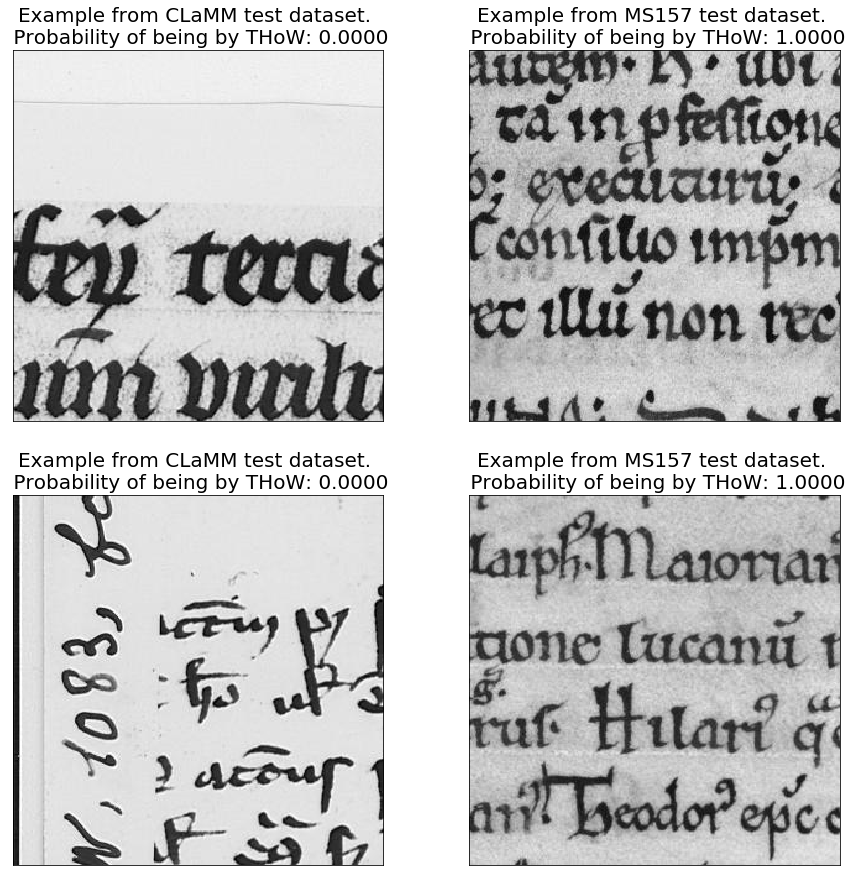

In [22]:
# Plot images from datasets, with added labels for probabilities of belonging to a class
CL_sample = mpimg.imread(str(CLaMM_test_data_files[25]))
THoW_sample = mpimg.imread(str(THoW_test_data_files[25]))

CL_sample2 = mpimg.imread(str(CLaMM_test_data_files[75]))
THoW_sample2 = mpimg.imread(str(THoW_test_data_files[75]))

f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0][0].imshow(CL_sample)
axarr[0][0].set_title('Example from CLaMM test dataset. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(CL_sample.reshape(1,300,300,3))[0][0]), fontsize=20)
axarr[0][1].imshow(THoW_sample)
axarr[0][1].set_title('Example from MS157 test dataset. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(THoW_sample.reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[1][0].imshow(CL_sample2)
axarr[1][0].set_title('Example from CLaMM test dataset. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(CL_sample2.reshape(1,300,300,3))[0][0]), fontsize=20)
axarr[1][1].imshow(THoW_sample2)
axarr[1][1].set_title('Example from MS157 test dataset. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(THoW_sample2.reshape(1,300,300,3))[0][0]), fontsize=20)

for ax in axarr[0]:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axarr[1]:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('correct.jpg', bbox_inches='tight')

In [24]:
def find_weird_examples(testfiles, classval):
    clamm_errors = []
    for file in testfiles:
        data_array = mpimg.imread(str(file)).reshape(1,300,300,3)                                  
        if not np.isclose(model.predict(data_array)[0][0], classval, rtol=0.5):
            clamm_errors.append(file)
    return clamm_errors

Clamm_errors = find_weird_examples(CLaMM_test_data_files,0)
THoW_errors = find_weird_examples(THoW_test_data_files,1)

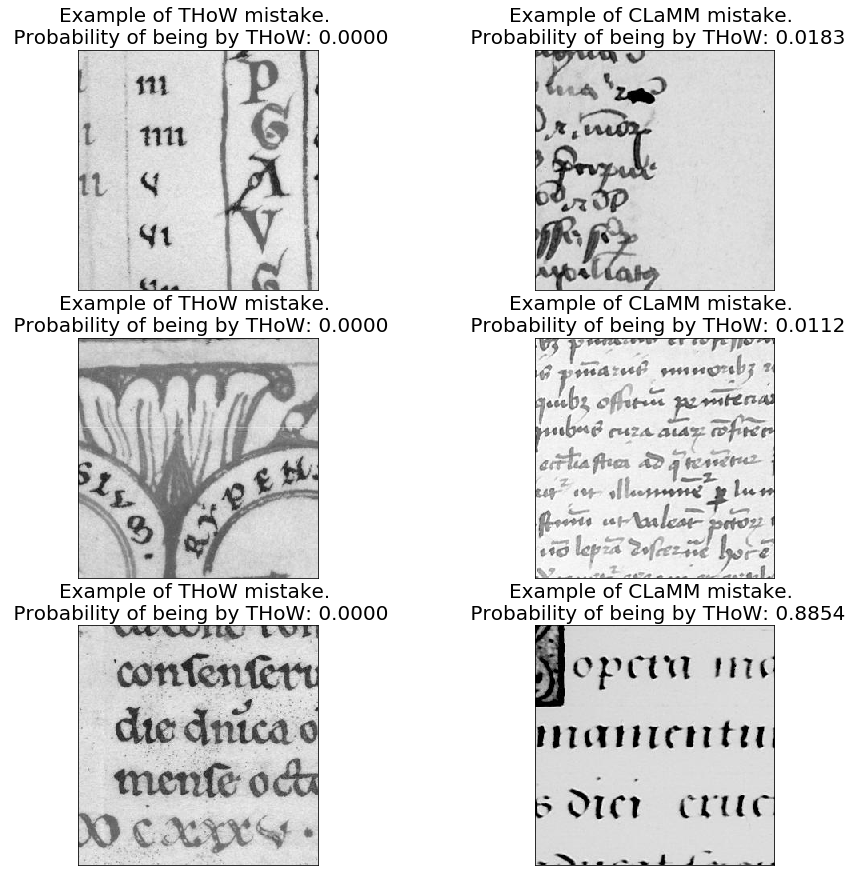

In [25]:
def get_mistakes(error_list):
    mistakes_array = []
    for file in error_list:
        data_array = mpimg.imread(str(file))
        mistakes_array.append(data_array)
    return mistakes_array

THoW_mistakes_list = get_mistakes(THoW_errors)
CLaMM_mistakes_list = get_mistakes(Clamm_errors)

f, axarr = plt.subplots(3,2,figsize=(15,15))
axarr[0][0].imshow(THoW_mistakes_list[0])
axarr[0][0].set_title('Example of THoW mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(THoW_mistakes_list[0].reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[1][0].imshow(THoW_mistakes_list[1])
axarr[1][0].set_title('Example of THoW mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(THoW_mistakes_list[1].reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[2][0].imshow(THoW_mistakes_list[2])
axarr[2][0].set_title('Example of THoW mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(THoW_mistakes_list[2].reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[0][1].imshow(CLaMM_mistakes_list[0])
axarr[0][1].set_title('Example of CLaMM mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(CLaMM_mistakes_list[0].reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[1][1].imshow(CLaMM_mistakes_list[1])
axarr[1][1].set_title('Example of CLaMM mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(CLaMM_mistakes_list[1].reshape(1,300,300,3))[0][0]), fontsize=20)

axarr[2][1].imshow(CLaMM_mistakes_list[2])
axarr[2][1].set_title('Example of CLaMM mistake. \n Probability of being by THoW: {:0.4f}'.format(
    model.predict(CLaMM_mistakes_list[2].reshape(1,300,300,3))[0][0]), fontsize=20)


for ax in axarr[0]:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axarr[1]:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axarr[2]:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('mistakes.jpg', bbox_inches='tight')

In [26]:
#TODO: tSNE for THoW/CLaMM at late CNN